In [182]:
import sys
import sqlite3
import math
import warnings
import struct
import itertools
import numpy as np
import scipy.fftpack
import scipy.signal
from matplotlib import pyplot as plt
import scipy.optimize
%matplotlib notebook

In [2]:
db = sqlite3.connect('test_run.sqlite3')

In [3]:
last_run, = db.execute('SELECT MAX(run_id) FROM packets').fetchone()
num_packets, = db.execute('SELECT COUNT(*) FROM packets WHERE run_id=?', (last_run,)).fetchone()
num_packets_distinct, = db.execute('SELECT COUNT(*) FROM (SELECT DISTINCT data FROM packets WHERE run_id=?)', (last_run,)).fetchone()
timespan_start, timespan_end = db.execute('SELECT MIN(timestamp_us)/1e6, MAX(timestamp_us)/1e6 FROM packets WHERE run_id=?', (last_run,)).fetchone()
timespan = timespan_end - timespan_start
print(f'Last run was ID #{last_run} with {num_packets} packets total, {num_packets_distinct} distinct over {timespan}s')

Last run was ID #2 with 1759 packets total, 504 distinct over 409.4534661769867s


In [4]:
timestamps = db.execute('SELECT timestamp_us/1e6 FROM packets WHERE run_id=? ORDER BY timestamp_us', (last_run,)).fetchall()
timestamps = [ ts - timespan_start for ts, in timestamps ]
deltas = [ b-a for a, b in zip(timestamps[:-1], timestamps[1:]) ]

<IPython.core.display.Javascript object>


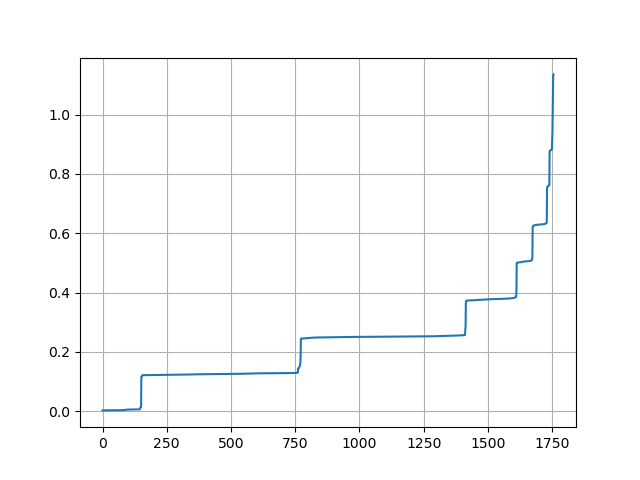

In [201]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(sorted(deltas)[:-2])

In [72]:
def fun(x, args):
    deltas, = args # poor api
    return np.sqrt(np.mean([ ((val + 0.5*x[0]) % x[0] - 0.5*x[0])**2 for val in deltas ]))
res = scipy.optimize.minimize(fun, 0.1, args=[sorted(deltas)[:-2]])
interval = np.abs(res.x[0])
print(f'Average speed of rotation: {1/interval:.2f} Hz / {60 / interval:.0f} rpm')

Average speed of rotation: 7.94 Hz / 476 rpm


In [78]:
packet_lengths = db.execute('SELECT LENGTH(data) FROM packets WHERE run_id=? GROUP BY LENGTH(data)', (last_run,)).fetchall()
assert len(packet_lengths) == 1
packet_len, = packet_lengths[0]
print('Packet length:', packet_len)

Packet length: 40


In [97]:
approx_baudrate = 1.0 / (np.mean([ x for x in deltas if x < interval*0.1 ]) / (packet_len*10))
print(f'Very approximate lower bound on baudrate: {approx_baudrate} bd')

Very approximate lower bound on baudrate: 92476.55870407648 bd


In [152]:
def decode_packet(packet):
    seq, *data, _crc = struct.unpack('<I16hI', packet)
    return (seq, tuple(data))

packets = sorted([ decode_packet(data) for data, in db.execute('SELECT data FROM packets WHERE run_id=?', (last_run,)) ])

In [154]:
# group packets by sequence number
by_seq = { k: list(g) for k, g in itertools.groupby(packets, key=lambda x: x[0]) }
for seq, le_packets in by_seq.items():
    # make sure we only ever have one version of a packet with a particular sequence number (no CRC collisions)
    if len(set(le_packets)) > 1:
        # In test_run.sqlite3 run 2 this happens to coincide with the time I intentionally bumped the rotor... ?
        warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')
        print('BUG: Duplicate sequence number')
        print('Sequence number:', seq)
        for seq, data in set(le_packets):
            print('   ', data)

BUG: Duplicate sequence number
Sequence number: 241
    (-53, -80, -12, 44, 11, -67, -61, 5, 47, -7, -74, -59, 15, 50, -18, -80)
    (43, 52, -14, -63, -32, 45, 60, -8, -59, -25, 44, 67, -1, -61, -25, 36)
BUG: Duplicate sequence number
Sequence number: 242
    (-59, -25, 44, 67, -1, -61, -25, 36, 72, -2, -54, 6, 96, 98, 26, -20)
    (47, -7, -74, -59, 15, 50, -18, -80, -49, 28, 31, -38, -86, -41, 36, 27)
BUG: Duplicate sequence number
Sequence number: 243
    (-49, 28, 31, -38, -86, -41, 36, 27, -50, -74, -18, 39, 26, -61, -74, -1)
    (72, -2, -54, 6, 96, 98, 26, -20, 21, 88, 73, -14, -26, 50, 95, 54)
BUG: Duplicate sequence number
Sequence number: 244
    (-50, -74, -18, 39, 26, -61, -74, -1, 53, 5, -67, -61, 8, 38, -13, -74)
    (21, 88, 73, -14, -26, 50, 95, 54, -32, -24, 22, 92, 30, -29, -8, 62)


<ipython-input-154-25bc058f475a>:7: UserWarning: BUG: Duplicate sequence number 241 for 2 payloads!
  warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')
<ipython-input-154-25bc058f475a>:7: UserWarning: BUG: Duplicate sequence number 242 for 2 payloads!
  warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')
<ipython-input-154-25bc058f475a>:7: UserWarning: BUG: Duplicate sequence number 243 for 2 payloads!
  warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')
<ipython-input-154-25bc058f475a>:7: UserWarning: BUG: Duplicate sequence number 244 for 2 payloads!
  warnings.warn(f'BUG: Duplicate sequence number {seq} for {len(set(le_packets))} payloads!')


In [155]:
seqs = list(by_seq)
print(f'Sequence number range: {min(seqs)} ... {max(seqs)}')

Sequence number range: 1 ... 510


In [166]:
# FIXME this is only approximate, doesn't consider sequence numbers properly!!!
reassembled_values = np.array([ val for (_seq, values), *_rest in by_seq.values() for val in values[:8] ])

<IPython.core.display.Javascript object>


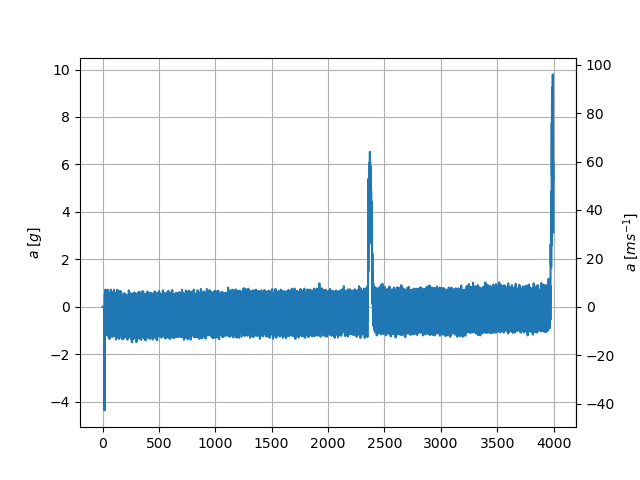

Text(0, 0.5, '$a\\; [ms^{-1}]$')

In [206]:
mems_lsb_per_g = 68 # LSBs per 1g for our accelerometer

fig, ax = plt.subplots()
ax.plot(reassembled_values / mems_lsb_per_g )
ax.grid()

g = 9.8066
g_to_ms = lambda x: x * g
ms_to_g = lambda x: x / g

ax.set_ylabel(r'$a\; [g]$')
secax_y = ax.secondary_yaxis(
    'right', functions=(g_to_ms, ms_to_g))
secax_y.set_ylabel(r'$a\; [ms^{-1}]$')

Largest peak at 3.1162324649298596 Hz / 186.97394789579158 rpm


<IPython.core.display.Javascript object>


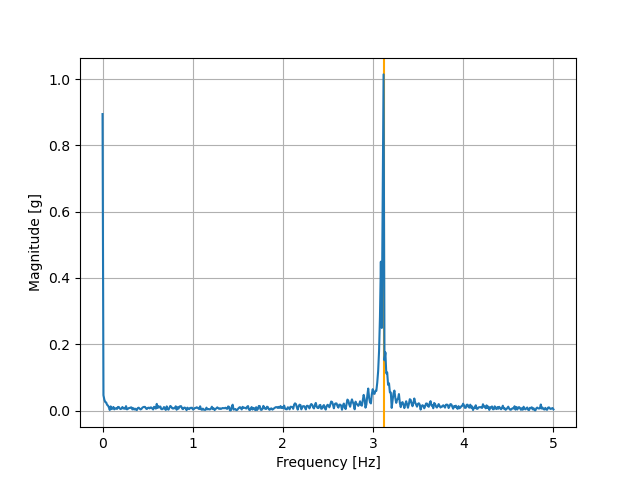

Text(0.5, 0, 'Frequency [Hz]')

In [210]:
sampling_rate = 10 # sps, set in firmware

N = 1000
T = 1/sampling_rate
x = np.linspace(0.0, N*T, N)
y = reassembled_values[500:2000] / mems_lsb_per_g # cut out beginning and that time we tapped the thing
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1/(2*T), N//2)
mag = 2/N * np.abs(yf[:N//2])

peaks, _ = scipy.signal.find_peaks(mag, height=.1, distance=1/T)
assert peaks

peak_data = sorted([ (-mag[idx], xf[idx]) for idx in peaks ])
largest_peak_f = peak_data[0][1]
print(f'Largest peak at {largest_peak_f:.2} Hz / {largest_peak_f * 60:.0} rpm')

fig, ax = plt.subplots()
ax.grid()
ax.axvline(xf[peaks], color='orange')
ax.plot(xf, mag)
ax.set_ylabel('Magnitude [g]')
ax.set_xlabel('Frequency [Hz]')


In [ ]:
fig, ax = plt.subplots()
ax.magnitude_spectrum(reassembled_values[500:2000]/mems_lsb_per_g)

In [217]:
r_mems = 55e-3 # radius of our sensor from the axis of rotation in m
f = largest_peak_f
omega = 2*np.pi*f # angular velocity
centrifugal_acceleration = omega**2 * r_mems # m/s^2
print(f'Centrifugal acceleration at {largest_peak_f:.2f} Hz: {centrifugal_acceleration:.2f} m/s^2 / {centrifugal_acceleration/g:.2f} g')

Centrifugal acceleration at 3.12 Hz: 21.09 m/s^2 / 2.15 g
